In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
import pandas as pd
sys.path.append('../pytools')
import d2l
import hashlib
import os
import tarfile
import zipfile
import requests

d2l.gpu_mem_init()

2025-09-15 14:47:10.921078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 14:47:10.984191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-15 14:47:12.491879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[0:2,[-4,-3,-2,-1]])
print(test_data.iloc[0:2,[-4,-3,-2,-1]])

   YrSold SaleType SaleCondition  SalePrice
0    2008       WD        Normal     208500
1    2007       WD        Normal     181500
   MoSold  YrSold SaleType SaleCondition
0       6    2010       WD        Normal
1       6    2010       WD        Normal


In [9]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))
print(all_features.iloc[0:1,[0,1,2,3,-3,-2,-1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal


In [10]:
num_fea = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[num_fea] = all_features[num_fea].apply(lambda x : ((x - x.mean()) / x.std() ))
all_features[num_fea] = all_features[num_fea].fillna(0)

In [11]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [12]:
n_train = train_data.shape[0]
train_fea = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_fea = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(train_data.SalePrice.values.reshape(-1,1), dtype=tf.float32)

I0000 00:00:1757918833.878948   76345 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31135 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0


In [21]:
loss = tf.keras.losses.MeanSquaredError()
def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

AttributeError: 'MeanSquaredError' object has no attribute 'device'

In [14]:
def log_rmse(y_true, y_pred):
    clip_pred = tf.clip_by_value(y_pred, 1.0, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(tf.math.log(y_true), tf.math.log(clip_pred))))

In [15]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
      train_ls,test_ls = [],[]
      train_iter = d2l.load_array((train_features, train_labels), train_fea.shape[0], batch_size)
      optimizer = tf.keras.optimizers.Adam(learning_rate)
      net.compile(loss=loss, optimizer=optimizer)
    
      for epoch in range(num_epochs):
            for x,y in train_iter:
                  with tf.GradientTape() as t:
                        y_hat = net(x)
                        l = loss(y, y_hat)
                  params = net.trainable_variables
                  grads  = t.gradient(l, params)
                  optimizer.apply_gradients(zip(grads, params))
            train_ls.append(log_rmse(train_labels, net(train_features)))
            if test_labels is not None:
                  test_ls.append(log_rmse(test_labels, net(test_features)))
      return train_ls,test_ls

In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse-{float(train_ls[-1]):f}, '
              f'验证log rmse-{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

2025-09-15 14:47:14.408480: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:237] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.0
2025-09-15 14:47:14.408504: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:240] Used ptxas at /usr/local/cuda/bin/ptxas
2025-09-15 14:47:14.408549: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-15 14:47:14.410632: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-15 14:47:14.413181: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-15 14:47:14.414994: W tensorflow/compiler/mlir/tools/kernel_gen/t

折1，训练log rmse-2.094562, 验证log rmse-2.106273


2025-09-15 14:47:19.358312: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


折2，训练log rmse-2.091384, 验证log rmse-2.114341


2025-09-15 14:47:22.625806: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


折3，训练log rmse-2.093711, 验证log rmse-2.107405
折4，训练log rmse-2.098622, 验证log rmse-2.081373
折5，训练log rmse-2.095505, 验证log rmse-2.097433
5-折验证: 平均训练log rmse: 2.094757, 平均验证log rmse: 2.101365


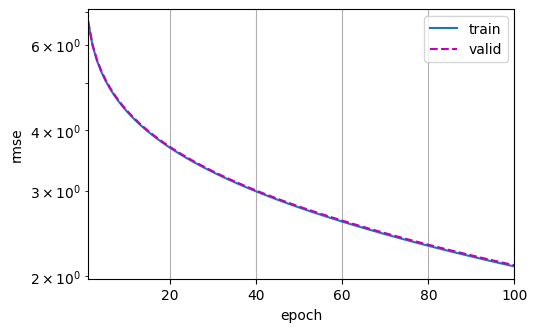

In [18]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5.0, 1, 64
train_l, valid_l = k_fold(k, train_fea, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [19]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

2025-09-15 14:47:29.409814: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


训练log rmse：2.095490


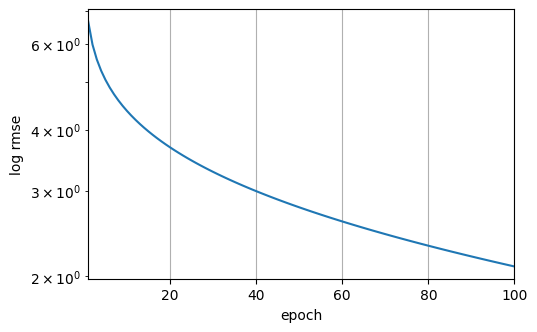

In [20]:
train_and_pred(train_fea, test_fea, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [23]:
x = tf.constant([0,1,2,3,4])
x.device

'/job:localhost/replica:0/task:0/device:GPU:0'